# Feature importance UD POS

### Imports

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn import tree
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
import lang2vec.lang2vec as l2v
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import chi2_contingency
from datetime import datetime

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth',None)
NFOLDS = 10
SEED = 7

### Set arguments

In [3]:
overwrite_chi2 = False
remove_correlated = False
encoding = "ordinal"
use_syn_dist=True
remove_weird_pairs = True
is_same = False
selection = "all"

### Load data

#### Load table with language features

In [4]:
lang_feats = pd.read_excel("../../xtreme_langs_wals.xlsx", index_col=0)

In [5]:
lang_feats.head()

,ISO 693-2,wals_code,iso_code,glottocode,Name,latitude,longitude,genus,family,#feats,macroarea,countrycodes,20A Fusion of Selected Inflectional Formatives,21A Exponence of Selected Inflectional Formatives,22A Inflectional Synthesis of the Verb,23A Locus of Marking in the Clause,24A Locus of Marking in Possessive Noun Phrases,25A Locus of Marking: Whole-language Typology,26A Prefixing vs. Suffixing in Inflectional Morphology,27A Reduplication,28A Case Syncretism,29A Syncretism in Verbal Person/Number Marking,30A Number of Genders,31A Sex-based and Non-sex-based Gender Systems,32A Systems of Gender Assignment,33A Coding of Nominal Plurality,34A Occurrence of Nominal Plurality,35A Plurality in Independent Personal Pronouns,36A The Associative Plural,37A Definite Articles,38A Indefinite Articles,39A Inclusive/Exclusive Distinction in Independent Pronouns,40A Inclusive/Exclusive Distinction in Verbal Inflection,41A Distance Contrasts in Demonstratives,42A Pronominal and Adnominal Demonstratives,43A Third Person Pronouns and Demonstratives,44A Gender Distinctions in Independent Personal Pronouns,45A Politeness Distinctions in Pronouns,46A Indefinite Pronouns,47A Intensifiers and Reflexive Pronouns,48A Person Marking on Adpositions,49A Number of Cases,50A Asymmetrical Case-Marking,51A Position of Case Affixes,52A Comitatives and Instrumentals,53A Ordinal Numerals,54A Distributive Numerals,55A Numeral Classifiers,56A Conjunctions and Universal Quantifiers,57A Position of Pronominal Possessive Affixes,58A Obligatory Possessive Inflection,59A Possessive Classification,"60A Genitives, Adjectives and Relative Clauses",61A Adjectives without Nouns,62A Action Nominal Constructions,63A Noun Phrase Conjunction,64A Nominal and Verbal Conjunction,65A Perfective/Imperfective Aspect,66A The Past Tense,67A The Future Tense,68A The Perfect,69A Position of Tense-Aspect Affixes,70A The Morphological Imperative,71A The Prohibitive,72A Imperative-Hortative Systems,73A The Optative,74A Situational Possibility,75A Epistemic Possibility,76A Overlap between Situational and Epistemic Modal Marking,77A Semantic Distinctions of Evidentiality,78A Coding of Evidentiality,79A Suppletion According to Tense and Aspect,80A Verbal Number and Suppletion,"81A Order of Subject, Object and Verb",82A Order of Subject and Verb,83A Order of Object and Verb,"84A Order of Object, Oblique, and Verb",85A Order of Adposition and Noun Phrase,86A Order of Genitive and Noun,87A Order of Adjective and Noun,88A Order of Demonstrative and Noun,89A Order of Numeral and Noun,90A Order of Relative Clause and Noun,91A Order of Degree Word and Adjective,92A Position of Polar Question Particles,93A Position of Interrogative Phrases in Content Questions,94A Order of Adverbial Subordinator and Clause,95A Relationship between the Order of Object and Verb and the Order of Adposition and Noun Phrase,96A Relationship between the Order of Object and Verb and the Order of Relative Clause and Noun,97A Relationship between the Order of Object and Verb and the Order of Adjective and Noun,98A Alignment of Case Marking of Full Noun Phrases,99A Alignment of Case Marking of Pronouns,100A Alignment of Verbal Person Marking,101A Expression of Pronominal Subjects,102A Verbal Person Marking,103A Third Person Zero of Verbal Person Marking,104A Order of Person Markers on the Verb,105A Ditransitive Constructions: The Verb 'Give',106A Reciprocal Constructions,107A Passive Constructions,108A Antipassive Constructions,109A Applicative Constructions,110A Periphrastic Causative Constructions,111A Nonperiphrastic Causative Constructions,112A Negative Morphemes,113A Symmetric and Asymmetric Standard Negation,114A Subtypes of Asymmetric Standard Negation,115A Negative Indefinite Pronouns and Predicate Negation,116A Polar Questions,117A Predicative Possession,118A Predicative Adjectives,119A Nominal and Locational Predication,120A Zero Copula for Predicate Nominals,121A Comparative Constructions,122A Relativization on S

In [6]:
lang_feats.shape

(40, 185)

#### Load language pairs with scores

In [7]:
pair_scores = pd.read_csv("lang_pair_scores.csv")

In [8]:
pair_scores.head()

,train_lang,test_lang,acc,f1
0,af,af,0.984390,0.982330
1,af,ar,0.587932,0.517718
2,af,bg,0.847598,0.834094
3,af,de,0.837953,0.828865
4,af,el,0.800967,0.779682


In [9]:
feat_cols = lang_feats.dropna(axis=1,how='all').columns[12:]

### Feature correlation

In [10]:
if overwrite_chi2:
    chi2 = {"col1":[],"col2":[],"chi2":[],"p":[],"result":[]}
    alpha = 0.05

    for i, col1 in enumerate(feat_cols):
        for j, col2 in enumerate(feat_cols):
            if i<j:
                table = pd.crosstab(lang_feats[col1],lang_feats[col2])
                try:
                    chi, p, dof, expected = chi2_contingency(table)
                except:
                    print("Error", col1, col2)
                    continue

                if p <= alpha:
                    result = 'Dependent (reject H0)'
                else:
                    result = 'Independent (fail to reject H0)'
                chi2["col1"].append(col1)
                chi2['col2'].append(col2)
                chi2['chi2'].append(chi)
                chi2['p'].append(p)
                chi2['result'].append(result)
    chi2 = pd.DataFrame.from_dict(chi2)
    chi2.to_csv("chi_correlations.csv")
else:
    chi2 = pd.read_csv("chi_correlations.csv")
    
chi2.head()

,col1,col2,chi2,p,result
0,20A Fusion of Selected Inflectional Formatives,21A Exponence of Selected Inflectional Formatives,10.492063,0.572875,Independent (fail to reject H0)
1,20A Fusion of Selected Inflectional Formatives,22A Inflectional Synthesis of the Verb,20.773449,0.187384,Independent (fail to reject H0)
2,20A Fusion of Selected Inflectional Formatives,23A Locus of Marking in the Clause,16.924242,0.152469,Independent (fail to reject H0)
3,20A Fusion of Selected Inflectional Formatives,24A Locus of Marking in Possessive Noun Phrases,32.711111,0.008069,Dependent (reject H0)
4,20A Fusion of Selected Inflectional Formatives,25A Locus of Marking: Whole-language Typology,25.714286,0.011778,Dependent (reject H0)


In [11]:
chi2.sort_values(by="chi2",ascending=False).head()

,col1,col2,chi2,p,result
12106,"144A Position of Negative Word With Respect to Subject, Object, and Verb",143A Order of Negative Morpheme and Verb,166.956522,8.092382e-17,Dependent (reject H0)
7918,"81A Order of Subject, Object and Verb","144A Position of Negative Word With Respect to Subject, Object, and Verb",93.367347,4.210062e-11,Dependent (reject H0)
945,26A Prefixing vs. Suffixing in Inflectional Morphology,33A Coding of Nominal Plurality,84.576087,2.465659e-11,Dependent (reject H0)
4297,49A Number of Cases,"144A Position of Negative Word With Respect to Subject, Object, and Verb",80.337088,3.156887e-03,Dependent (reject H0)
12398,143A Order of Negative Morpheme and Verb,144L The Position of Negative Morphemes in SOV Languages,80.000000,1.141061e-07,Dependent (reject H0)


In [12]:
feat_cols = list(feat_cols)

In [13]:
chi2.result.value_counts()

Independent (fail to reject H0)    10965
Dependent (reject H0)               1543
Name: result, dtype: int64

In [14]:
if remove_correlated:
    correlated = chi2[chi2.result=="Dependent (reject H0)"].col2.unique()
    for feat in correlated:
        feat_cols.remove(feat)

### Prepare dataset

Prepare a dataset for training a model to predict accuracy of a language pair

In [15]:
final_arr = []


if is_same:
    for i in pair_scores.index:
        train_lang = pair_scores.at[i,"train_lang"]
        test_lang = pair_scores.at[i,"test_lang"]
        
        switched_acc = pair_scores[(pair_scores.train_lang==test_lang)&(pair_scores.test_lang==train_lang)].acc.values[0]
        avg_acc = (switched_acc+pair_scores.at[i,"acc"])/2
        
        switched_f1 = pair_scores[(pair_scores.train_lang==test_lang)&(pair_scores.test_lang==train_lang)].f1.values[0]
        avg_f1 = (switched_acc+pair_scores.at[i,"f1"])/2
        
        train_feats = [train_lang, test_lang,avg_acc, avg_f1] + list((lang_feats.loc[train_lang,feat_cols]==lang_feats.loc[test_lang,feat_cols]).values)
        final_arr.append(train_feats)
        
    feat_cols = ["is_"+col.split()[0]+"_same" for col in feat_cols]
else:
    for i in pair_scores.index:
        train_lang = pair_scores.at[i,"train_lang"]
        test_lang = pair_scores.at[i,"test_lang"]
        train_feats =  list(pair_scores.iloc[i,:].values) + list(lang_feats.loc[train_lang,feat_cols].values) + list(lang_feats.loc[test_lang,feat_cols].values)
        final_arr.append(train_feats)
        
    feat_cols = [col.split()[0]+"_train" for col in feat_cols]+ [col.split()[0]+"_test" for col in feat_cols]
    
final_cols = list(pair_scores.columns)+feat_cols

final_df = pd.DataFrame(data=final_arr,columns=final_cols)

In [16]:
final_df = final_df.drop_duplicates(subset='acc')

In [17]:
final_df.shape

(827, 324)

Keep only zero-shot learning pairs

In [18]:
final_df = final_df[final_df['train_lang']!=final_df['test_lang']]

### Kruskal correlation between target and every feature per lang

In [19]:
import scipy.stats as stats
def kruskal_per_lang(x):
    kruskal = {"test_lang":[],"feature":[],"h":[],"p":[],"result":[]}
    alpha = 0.05
    test_feats = [col for col in x.columns if "_train" in col]
    assert len(test_feats)>0,"Set is_same to False"
    test_lang = x.iat[0,1]
    for col in test_feats:
        col_df = x[[col,'acc']].dropna()
        if col_df[col].nunique()>1:
            groups = [list(col_df[col_df[col]==value].acc.values) for value in col_df[col].unique()]
            h, p = stats.kruskal(*groups)
            if p<alpha:
                result = 'Dependent (reject H0)'
            else:
                result = 'Independent (fail to reject H0)'
            kruskal["test_lang"].append(test_lang)
            kruskal['feature'].append(col)
            kruskal['h'].append(h)
            kruskal['p'].append(p)
            kruskal['result'].append(result)
    
    kruskal = pd.DataFrame.from_dict(kruskal)
    return kruskal

kruskal_test = final_df.groupby(by="test_lang").apply(kruskal_per_lang).reset_index(drop=True)
min_p_ixs = kruskal_test.groupby(by='test_lang').p.idxmin()
most_corr_per_lang = kruskal_test.loc[min_p_ixs,:]
most_corr_per_lang

,test_lang,feature,h,p,result
89,af,115A_train,13.514706,0.001162,Dependent (reject H0)
195,ar,86A_train,14.571429,0.000685,Dependent (reject H0)
333,bg,93A_train,14.717577,0.000637,Dependent (reject H0)
493,de,121A_train,12.339683,0.002092,Dependent (reject H0)
609,el,103A_train,12.886364,0.001591,Dependent (reject H0)
791,en,21B_train,9.356209,0.009297,Dependent (reject H0)
856,es,86A_train,15.264143,0.000485,Dependent (reject H0)
995,et,93A_train,13.379784,0.001243,Dependent (reject H0)
1095,eu,55A_train,11.500000,0.003183,Dependent (reject H0)
1251,fa,85A_train,15.581633,0.000414,Dependent (reject H0)


In [20]:
import seaborn as sns

def plot_most_corr(x):
    test_lang = x.iat[0,0]
    most_corr_feat = x.iat[0,1]
    ax = sns.barplot(x=most_corr_feat, y="acc", data=final_df[final_df.test_lang==test_lang])
    plt.title("Most correlated feature for {}".format(test_lang))
    plt.xticks(rotation=30)
    plt.ylim([0,1])
    plt.show()
    
kpl = True
if kpl:    
#     most_corr_per_lang.groupby(by="test_lang").apply(plot_most_corr)

    def output(x):
        print("Feature",x.iat[0,1])
        print("Langs",x.test_lang.unique())
        
    most_corr_per_lang.groupby(by="feature").apply(output)
    most_corr_per_lang['feature'].value_counts()



Feature 100A_train
Langs ['te' 'tr']
Feature 102A_train
Langs ['ta']
Feature 103A_train
Langs ['el']
Feature 115A_train
Langs ['af' 'hu']
Feature 121A_train
Langs ['de']
Feature 21B_train
Langs ['en']
Feature 29A_train
Langs ['mr']
Feature 55A_train
Langs ['eu']
Feature 64A_train
Langs ['ja' 'zh']
Feature 76A_train
Langs ['ko']
Feature 79A_train
Langs ['hi' 'ur']
Feature 85A_train
Langs ['fa']
Feature 86A_train
Langs ['ar' 'es' 'it' 'pt' 'vi']
Feature 90A_train
Langs ['fr']
Feature 93A_train
Langs ['bg' 'et' 'fi' 'he' 'id' 'nl' 'ru']


In [21]:
if kpl: 
#     show most important features aggregated for all langauges 
    kruskal_per_lang(final_df).drop(["test_lang"],axis=1).sort_values(by='p').head()

### Kruskal feature selection

In [22]:
if selection=="kruskal":
    alpha = 0.05
    dep_cols = []
    for col in feat_cols:
        col_df = final_df[[col,'acc']].dropna()
        if col_df[col].nunique()>1:
            groups = [list(col_df[col_df[col]==value].acc.values) for value in col_df[col].unique()]
            if stats.kruskal(*groups).pvalue<alpha:
                dep_cols.append(col)

Delete features that have only missing values

### Add syntactical distance

We are using ISO 369-2 and lang2vec is using ISO 369-3, but they mostly overlap. For UD POS only Malay does not have a precomputed distance (its ISO 369-1 is "ms", ISO 369-2 is "may" and ISO 369-3 is "mly"). Therefore we delete it from the list to avoid errors.

In [23]:
if use_syn_dist:
    lang_codes_2 = list(lang_feats['ISO 693-2'].values)
    lang_codes_2.remove("may")
    lang_codes_1 = list(lang_feats.index)
    lang_codes_1.remove("ms")
    synt_dist = pd.DataFrame(data=l2v.syntactic_distance(lang_codes_2),index=lang_codes_1,columns=lang_codes_1)

    for i in final_df.index:
        train_lang = final_df.at[i,"train_lang"]
        test_lang = final_df.at[i,"test_lang"]
        try:
            final_df.at[i,"syn_dist"] =  synt_dist.at[train_lang, test_lang]
        except:
            print("Language not in URIEL")
    #       TODO: for now just add a place holder for languages that are not in the URIEL database
            final_df.at[i,"syn_dist"] = -1

### Other preprocessing

#### Remove French test pairs, German-English pair and all Chinese and Japanese pairs

In [24]:
if remove_weird_pairs:
    removed_pairs = (final_df.train_lang.isin(['ja','zh'])) | (final_df.test_lang.isin(['fr','ja','zh'])) | ((final_df.train_lang=='de')&(final_df.test_lang=='en'))
    final_df = final_df[~removed_pairs]

In [25]:
final_df = final_df.dropna(axis=1,how='all')

### Fill missing values

In [26]:
cat_cols = list(final_df.select_dtypes(include=['object']).columns)

In [27]:
final_df[cat_cols] = final_df[cat_cols].fillna("0 Missing")

In [28]:
final_df.isna().any().any()

False

### Encode categorical variables (i.e. all of them)

In [29]:
if encoding=="ordinal":
    mappings = []
    for col in cat_cols:
        unique_vals = final_df[col].unique()
    #     every value of a WALS feature starts with an index number, additionally we mark missing as 0
        sorted_vals = sorted(unique_vals, key=lambda element: [element[0]])
        mappings.append(sorted_vals)

    oe = OrdinalEncoder(categories=mappings)
    oe.fit(final_df[cat_cols])
    final_df[cat_cols] = oe.transform(final_df[cat_cols])
elif encoding=="onehot":
    from sklearn.preprocessing import OneHotEncoder

    one_hot = pd.get_dummies(final_df[cat_cols])
    final_df = final_df.drop(cat_cols,axis=1)
    final_df = pd.concat([final_df,one_hot],axis=1)
    
    cols_with_brackets = [col for col in final_df.columns if '[' in col ]
    brackets_dict = {}
    for col in cols_with_brackets:
        brackets_dict[col] = re.sub("\[|\]", "", col) # remove square brackets
    final_df = final_df.rename(columns=brackets_dict)
else:
    raise Exception("Incorrect encoding name. Choose between \"ordinal\" and \"onehot\"")

### Functions for training and evaluation

In [30]:
def fold_metrics(model, x_train, y_train, x_val, y_val, metrics_dict,debug=False): 
    y_preds = model.predict(x_train)
    fold_train = np.sqrt(mean_squared_error(y_train,y_preds))
    
    y_preds_val = model.predict(x_val)
    fold_val = np.sqrt(mean_squared_error(y_val,y_preds_val))


    
    metrics_dict['train']['rmse'].append(fold_train)
    metrics_dict['test']['rmse'].append(fold_val)
    
    if debug:
        metrics = pd.DataFrame.from_dict({'train':[fold_train],
                                         'test':[fold_val]})
        metrics.index = ['rmse']
        display(metrics)

In [31]:
def mean_fold_metrics(metrics_dict):
    
    train_rmse = np.mean(metrics_dict['train']['rmse'])
    test_rmse = np.mean(metrics_dict['test']['rmse'])
                        
    metrics = pd.DataFrame.from_dict({'train':[train_rmse],'test':[test_rmse]})
    metrics.index = ['rmse']
    
    print()
    print("Mean fold metrics")
    display(metrics)
    return metrics

In [32]:
def train_model(X, y, folds, params=None, X_test=None, model_type='lgb',n_jobs=-1, n_estimators=None, plot_feature_importance=True,save_importance = True,verbose=500,early_stopping_rounds=None):
#     add n_estimators and early_stopping as arguments in lgbm
    print("Model type",model_type)
    metrics_dict = {'train':{'rmse':[]},
                   'test':{'rmse':[]}}
    result_dict = {}
    n_splits = folds.n_splits
    columns = X.columns
    # averaged predictions on test data
    if X_test is not None:
        prediction = np.zeros((len(X_test), 1))
    
    feature_importance = pd.DataFrame()
    
    if params is None:
        params = {}
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
#         print('Fold nr {}'.format(fold_n))
        X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        if model_type=='lgb':
            model = lgb.LGBMClassifier(**params, importance_type='gain')
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                    verbose=verbose)
    #         we want 0s and 1s for submission
            if X_test is not None:
                y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
        elif model_type=='xgb':
            model = xgb.XGBRegressor(**params,random_state=SEED)
            model.fit(X_train, y_train)
            #         we want 0s and 1s for submission
            if X_test is not None:
                y_pred = model.predict(X_test)
        elif model_type=='linear':
            model = LinearRegression()
            model.fit(X_train,y_train)
            if X_test is not None:
                y_pred = model.predict(X_test)
        elif model_type=='lasso':
            model = Lasso(random_state=SEED)
            model.fit(X_train,y_train)
            if X_test is not None:
                y_pred = model.predict(X_test)
        elif model_type=='dt':
            model = DecisionTreeRegressor(max_depth=10,max_leaf_nodes=10,random_state=SEED)
            model.fit(X_train,y_train)
            if X_test is not None:
                y_pred = model.predict(X_test)
        elif model_type=='rf':
            model = RandomForestRegressor(random_state=SEED)
            model.fit(X_train,y_train)
            if X_test is not None:
                y_pred = model.predict(X_test)
        else:
            raise Exception("Invalid model type")
                    
        fold_metrics(model,X_train,y_train,X_valid,y_valid,metrics_dict)
        
        if X_test is not None:
            prediction += y_pred.reshape(-1, 1)
        if plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    
    if X_test is not None:
        prediction /= n_splits
    
    result_dict['metrics'] = mean_fold_metrics(metrics_dict)
    if X_test is not None:
        result_dict['prediction'] = prediction.flatten()
        
    
    if plot_feature_importance:
        feature_importance["importance"] /= n_splits
        best_features = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance", ascending=False)[:50].reset_index(level=['feature'])


        plt.figure(figsize=(16, 12));
        sns.barplot(x="importance", y="feature", data=best_features);
        plt.title('{} Features (avg over folds) overwrite_chi2 = {} remove_correlated = {} encoding = {} use_syn_dist = {} remove_weird_pairs = {}'.format(model_type.upper(),
                                                    overwrite_chi2,
                                                    remove_correlated,
                                                    encoding,
                                                    use_syn_dist,
                                                    remove_weird_pairs));
        
        if save_importance:
            now = datetime.now() 
            now = now.strftime("%d_%m_%Y_%H_%M")
            plt.savefig("Feature importance {}.jpg".format(now),dpi=500, bbox_inches='tight')
        
        result_dict['feature_importance'] = feature_importance
        result_dict['top_columns'] = best_features['feature'].unique()
        
    return result_dict, model

### Train models

In [33]:
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

#### On all features

In [34]:
if selection=="all":
    if use_syn_dist:
        X = final_df.drop(['train_lang','test_lang','acc','f1','syn_dist'],axis=1)
    else:
        X = final_df.drop(['train_lang','test_lang','acc','f1'],axis=1)
    y = final_df['acc']
elif selection=="kruskal":
    X = final_df[dep_cols]
    y = final_df['acc']
elif selection=="stepwise":
    X = final_df[best_stepwise]
    y = final_df['acc']

Try different models and compare results

In [35]:
final_df.head()

,train_lang,test_lang,acc,f1,20A_train,21A_train,22A_train,23A_train,24A_train,25A_train,26A_train,27A_train,28A_train,29A_train,30A_train,31A_train,32A_train,33A_train,34A_train,35A_train,36A_train,37A_train,38A_train,39A_train,40A_train,41A_train,42A_train,43A_train,44A_train,45A_train,46A_train,47A_train,48A_train,49A_train,50A_train,51A_train,52A_train,53A_train,54A_train,55A_train,56A_train,57A_train,58A_train,59A_train,60A_train,61A_train,62A_train,63A_train,64A_train,65A_train,66A_train,67A_train,68A_train,69A_train,70A_train,71A_train,72A_train,73A_train,74A_train,75A_train,76A_train,77A_train,78A_train,79A_train,80A_train,81A_train,82A_train,83A_train,84A_train,85A_train,86A_train,87A_train,88A_train,89A_train,90A_train,91A_train,92A_train,93A_train,94A_train,95A_train,96A_train,97A_train,98A_train,99A_train,100A_train,101A_train,102A_train,103A_train,104A_train,105A_train,106A_train,107A_train,108A_train,109A_train,110A_train,111A_train,112A_train,113A_train,114A_train,115A_train,116A_train,117A_train,118A_train,119A_train,120A_train,121A_train,122A_train,123A_train,124A_train,125A_train,126A_train,127A_train,128A_train,129A_train,130A_train,131A_train,132A_train,133A_train,134A_train,135A_train,136A_train,137A_train,138A_train,142A_train,143F_train,90B_train,90C_train,144P_train,144J_train,144S_train,144X_train,144A_train,90E_train,144V_train,144I_train,144R_train,144M_train,144G_train,144K_train,144B_train,90D_train,144E_train,144D_train,81B_train,143E_train,143C_train,143A_train,144W_train,144Q_train,144L_train,144H_train,144C_train,144T_train,143G_train,137B_train,136B_train,109B_train,25B_train,21B_train,108B_train,58B_train,79B_train,20A_test,21A_test,22A_test,23A_test,24A_test,25A_test,26A_test,27A_test,28A_test,29A_test,30A_test,31A_test,32A_test,33A_test,34A_test,35A_test,36A_test,37A_test,38A_test,39A_test,40A_test,41A_test,42A_test,43A_test,44A_test,45A_test,46A_test,47A_test,48A_test,49A_test,50A_test,51A_test,52A_test,53A_test,54A_test,55A_test,56A_test,57A_test,58A_test,59A_test,60A_test,61A_test,62A_test,63A_test,64A_test,65A_test,66A_test,67A_test,68A_test,69A_test,70A_test,71A_test,72A_test,73A_test,74A_test,75A_test,76A_test,77A_test,78A_test,79A_test,80A_test,81A_test,82A_test,83A_test,84A_test,85A_test,86A_test,87A_test,88A_test,89A_test,90A_test,91A_test,92A_test,93A_test,94A_test,95A_test,96A_test,97A_test,98A_test,99A_test,100A_test,101A_test,102A_test,103A_test,104A_test,105A_test,106A_test,107A_test,108A_test,109A_test,110A_test,111A_test,112A_test,113A_test,114A_test,115A_test,116A_test,117A_test,118A_test,119A_test,120A_test,121A_test,122A_test,123A_test,124A_test,125A_test,126A_test,127A_test,128A_test,129A_test,130A_test,131A_test,132A_test,133A_test,134A_test,135A_test,136A_test,137A_test,138A_test,142A_test,143F_test,90B_test,90C_test,144P_test,144J_test,144S_test,144X_test,144A_test,90E_test,144V_test,144I_test,144R_test,144M_test,144K_test,144B_test,90D_test,144E_test,144D_test,81B_test,143E_test,143A_test,144W_test,144Q_test,144L_test,144H_test,144C_test,144T_test,143G_test,137B_test,136B_test,109B_test,25B_test,21B_test,108B_test,58B_test,79B_test,syn_dist
1,0.0,0.0,0.587932,0.517718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [36]:
for est in ['linear','lasso','dt','rf','xgb']:
    results, model = train_model(X,y,folds,params=None,model_type=est,plot_feature_importance=False)

Model type linear

Mean fold metrics


,train,test
rmse,0.07227,0.078164


Model type lasso

Mean fold metrics


,train,test
rmse,0.112861,0.112779


Model type dt

Mean fold metrics


,train,test
rmse,0.056071,0.06008


Model type rf

Mean fold metrics


,train,test
rmse,0.015996,0.042301


Model type xgb

Mean fold metrics


,train,test
rmse,0.002073,0.041884


XGBoost obtains slightly better results than RF, but the former overfits dramatically.

### Analysing feature importance

In [37]:
final_df.head()

,train_lang,test_lang,acc,f1,20A_train,21A_train,22A_train,23A_train,24A_train,25A_train,26A_train,27A_train,28A_train,29A_train,30A_train,31A_train,32A_train,33A_train,34A_train,35A_train,36A_train,37A_train,38A_train,39A_train,40A_train,41A_train,42A_train,43A_train,44A_train,45A_train,46A_train,47A_train,48A_train,49A_train,50A_train,51A_train,52A_train,53A_train,54A_train,55A_train,56A_train,57A_train,58A_train,59A_train,60A_train,61A_train,62A_train,63A_train,64A_train,65A_train,66A_train,67A_train,68A_train,69A_train,70A_train,71A_train,72A_train,73A_train,74A_train,75A_train,76A_train,77A_train,78A_train,79A_train,80A_train,81A_train,82A_train,83A_train,84A_train,85A_train,86A_train,87A_train,88A_train,89A_train,90A_train,91A_train,92A_train,93A_train,94A_train,95A_train,96A_train,97A_train,98A_train,99A_train,100A_train,101A_train,102A_train,103A_train,104A_train,105A_train,106A_train,107A_train,108A_train,109A_train,110A_train,111A_train,112A_train,113A_train,114A_train,115A_train,116A_train,117A_train,118A_train,119A_train,120A_train,121A_train,122A_train,123A_train,124A_train,125A_train,126A_train,127A_train,128A_train,129A_train,130A_train,131A_train,132A_train,133A_train,134A_train,135A_train,136A_train,137A_train,138A_train,142A_train,143F_train,90B_train,90C_train,144P_train,144J_train,144S_train,144X_train,144A_train,90E_train,144V_train,144I_train,144R_train,144M_train,144G_train,144K_train,144B_train,90D_train,144E_train,144D_train,81B_train,143E_train,143C_train,143A_train,144W_train,144Q_train,144L_train,144H_train,144C_train,144T_train,143G_train,137B_train,136B_train,109B_train,25B_train,21B_train,108B_train,58B_train,79B_train,20A_test,21A_test,22A_test,23A_test,24A_test,25A_test,26A_test,27A_test,28A_test,29A_test,30A_test,31A_test,32A_test,33A_test,34A_test,35A_test,36A_test,37A_test,38A_test,39A_test,40A_test,41A_test,42A_test,43A_test,44A_test,45A_test,46A_test,47A_test,48A_test,49A_test,50A_test,51A_test,52A_test,53A_test,54A_test,55A_test,56A_test,57A_test,58A_test,59A_test,60A_test,61A_test,62A_test,63A_test,64A_test,65A_test,66A_test,67A_test,68A_test,69A_test,70A_test,71A_test,72A_test,73A_test,74A_test,75A_test,76A_test,77A_test,78A_test,79A_test,80A_test,81A_test,82A_test,83A_test,84A_test,85A_test,86A_test,87A_test,88A_test,89A_test,90A_test,91A_test,92A_test,93A_test,94A_test,95A_test,96A_test,97A_test,98A_test,99A_test,100A_test,101A_test,102A_test,103A_test,104A_test,105A_test,106A_test,107A_test,108A_test,109A_test,110A_test,111A_test,112A_test,113A_test,114A_test,115A_test,116A_test,117A_test,118A_test,119A_test,120A_test,121A_test,122A_test,123A_test,124A_test,125A_test,126A_test,127A_test,128A_test,129A_test,130A_test,131A_test,132A_test,133A_test,134A_test,135A_test,136A_test,137A_test,138A_test,142A_test,143F_test,90B_test,90C_test,144P_test,144J_test,144S_test,144X_test,144A_test,90E_test,144V_test,144I_test,144R_test,144M_test,144K_test,144B_test,90D_test,144E_test,144D_test,81B_test,143E_test,143A_test,144W_test,144Q_test,144L_test,144H_test,144C_test,144T_test,143G_test,137B_test,136B_test,109B_test,25B_test,21B_test,108B_test,58B_test,79B_test,syn_dist
1,0.0,0.0,0.587932,0.517718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

#### By feature group

In [38]:
groups = {"morphology":list(range(20,30)),
"nom_cat":list(range(30, 58)),
"nom_synt":list(range(58, 65)),
"verb_cat":list(range(65, 81)),
"order":list(range(81, 98))+[143, 144],
"simp_claus":list(range(98, 122)),
"comp_sent":list(range(122, 129)),
"lexicon":list(range(129, 139)),
"other":list(range(141,143)),}


In [39]:
if encoding=="ordinal":
    final_feat_cols = final_df.columns[4:-1]
elif encoding=="onehot":
    final_feat_cols = final_df.columns[56:-1]
else:
    raise Exception("Select proper encoding.")

Group morphology
Model type rf

Mean fold metrics


,train,test
rmse,0.072227,0.087633


Group nom_cat
Model type rf

Mean fold metrics


,train,test
rmse,0.017872,0.046904


Group nom_synt
Model type rf

Mean fold metrics


,train,test
rmse,0.057115,0.079151


Group verb_cat
Model type rf

Mean fold metrics


,train,test
rmse,0.020234,0.055033


Group order
Model type rf

Mean fold metrics


,train,test
rmse,0.016393,0.040198


Group simp_claus
Model type rf

Mean fold metrics


,train,test
rmse,0.018982,0.049096


Group comp_sent
Model type rf

Mean fold metrics


,train,test
rmse,0.071364,0.092393


Group lexicon
Model type rf

Mean fold metrics


,train,test
rmse,0.039918,0.065147


Group other
Model type rf

Mean fold metrics


,train,test
rmse,0.109925,0.111144


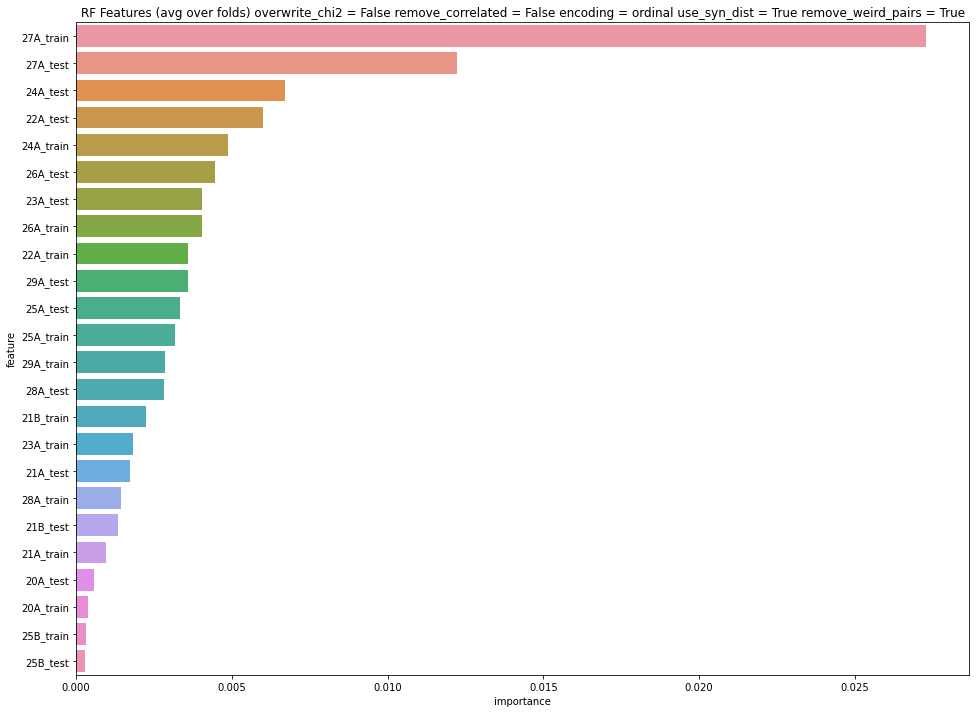

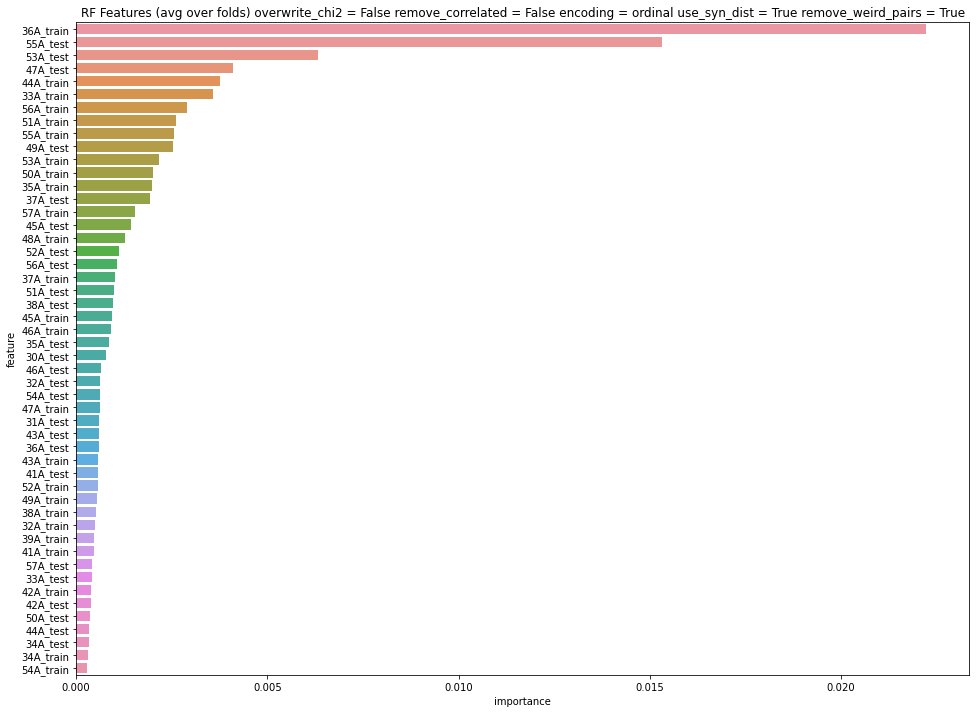

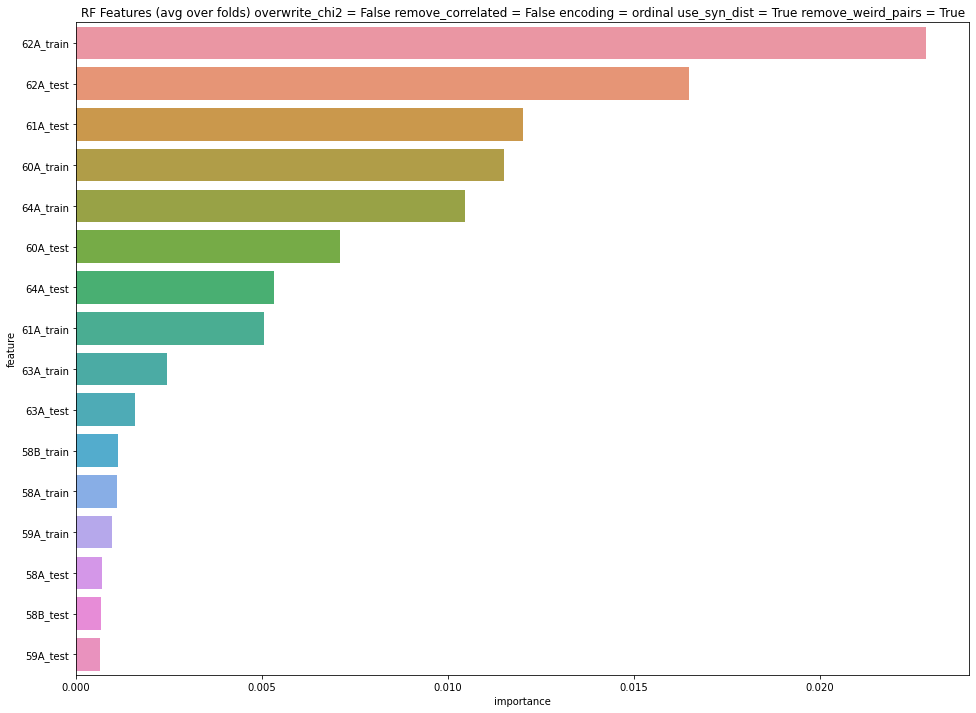

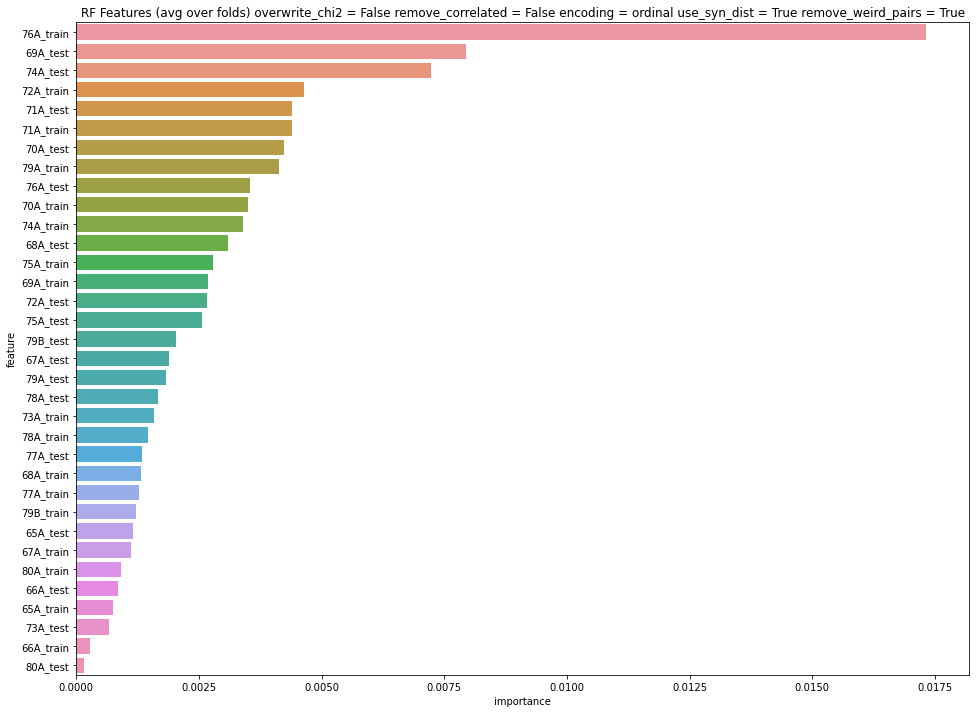

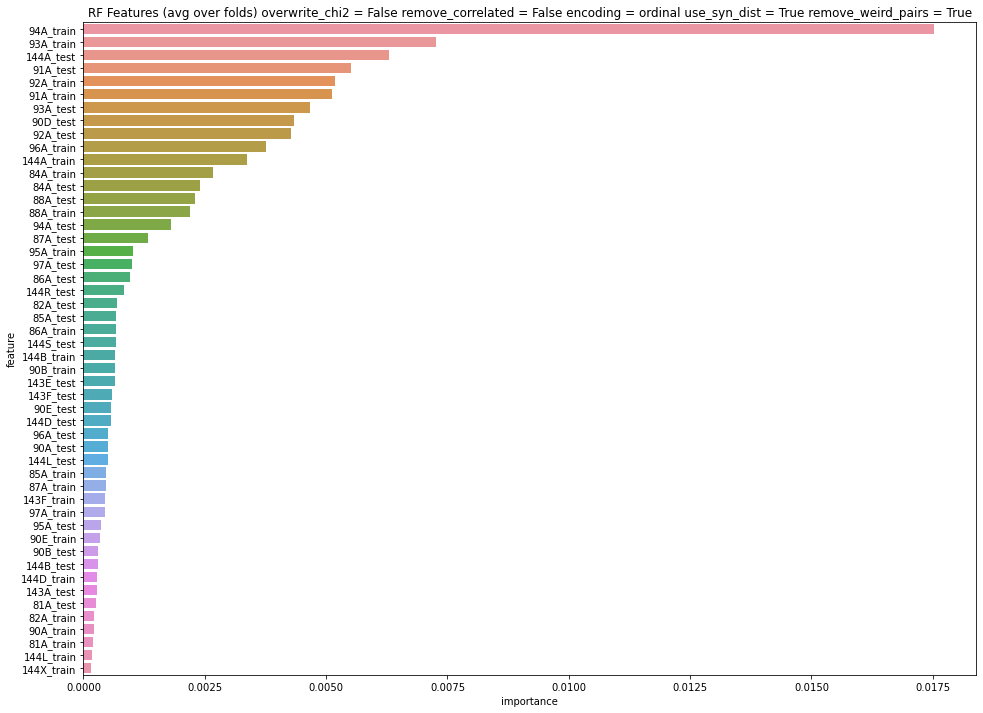

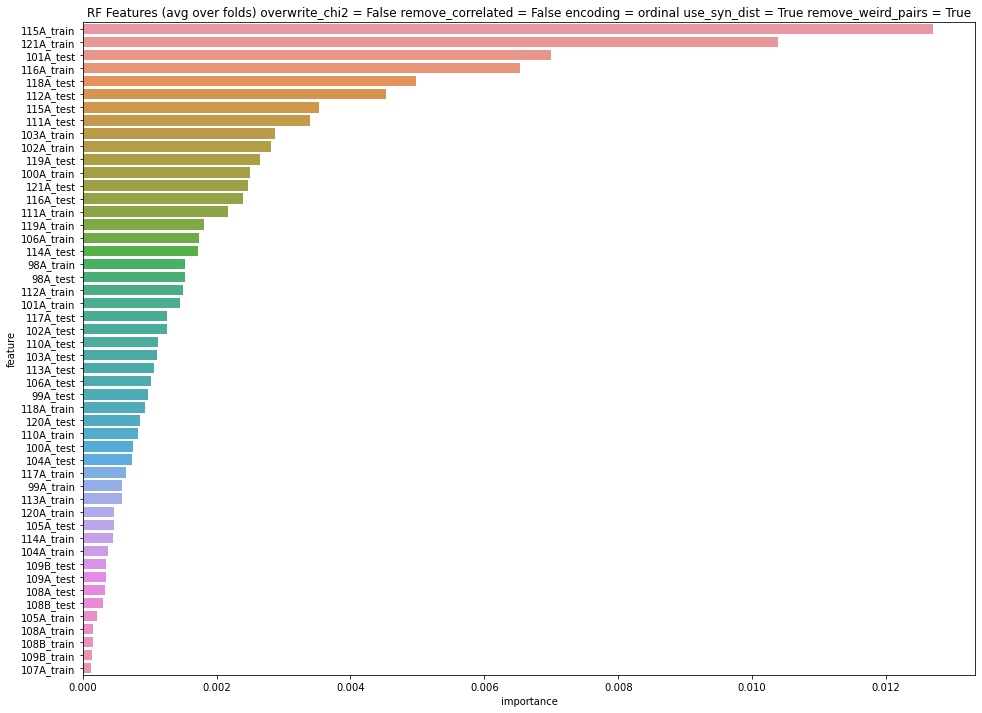

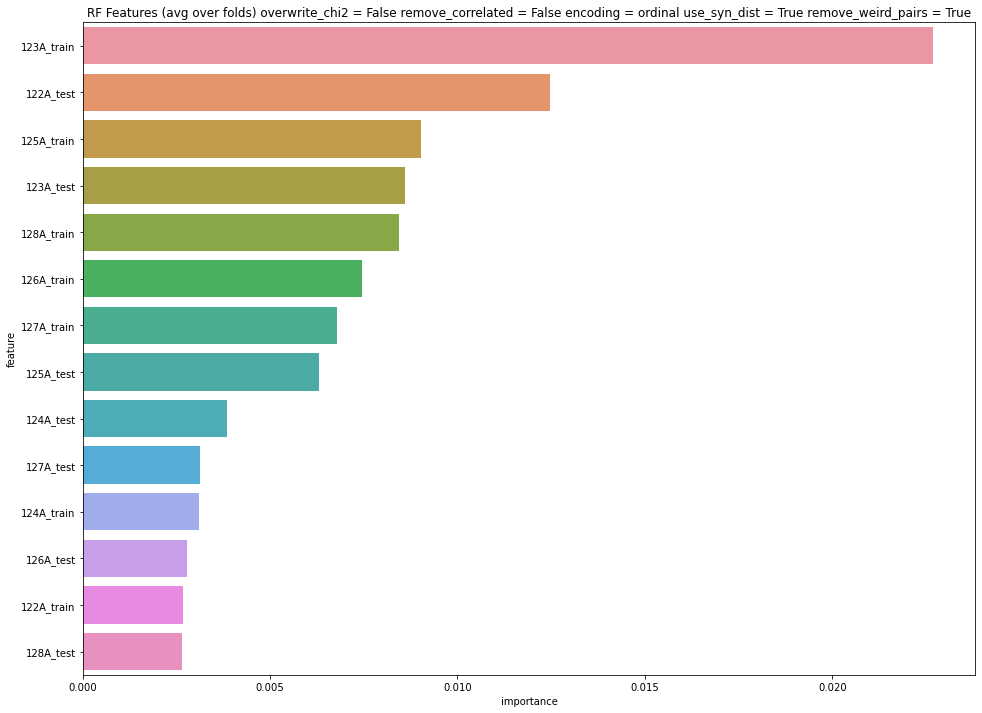

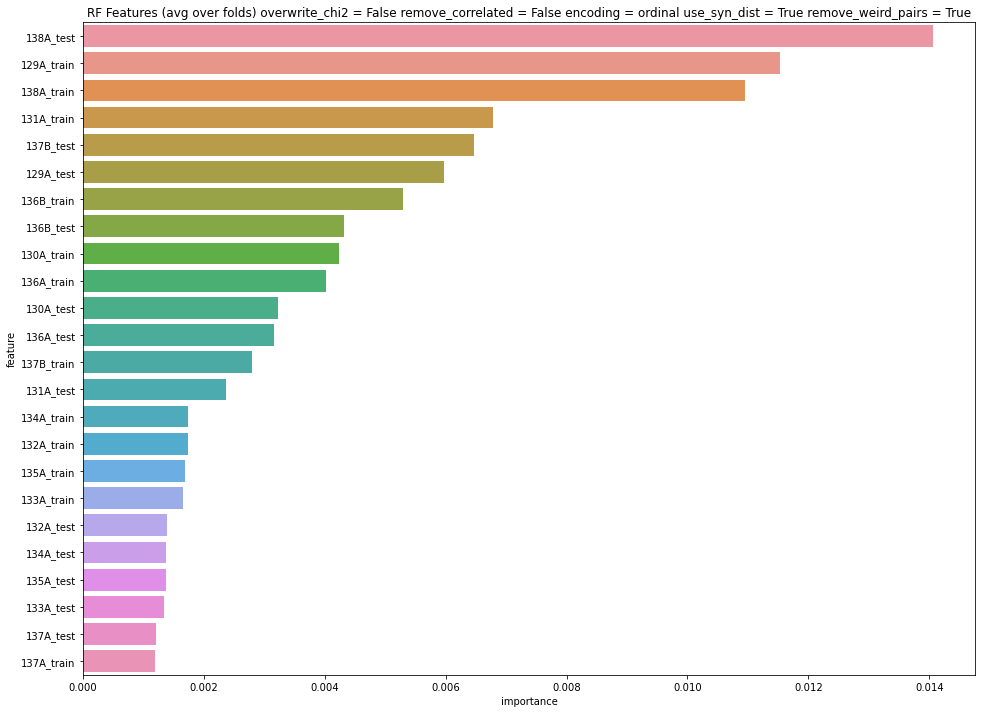

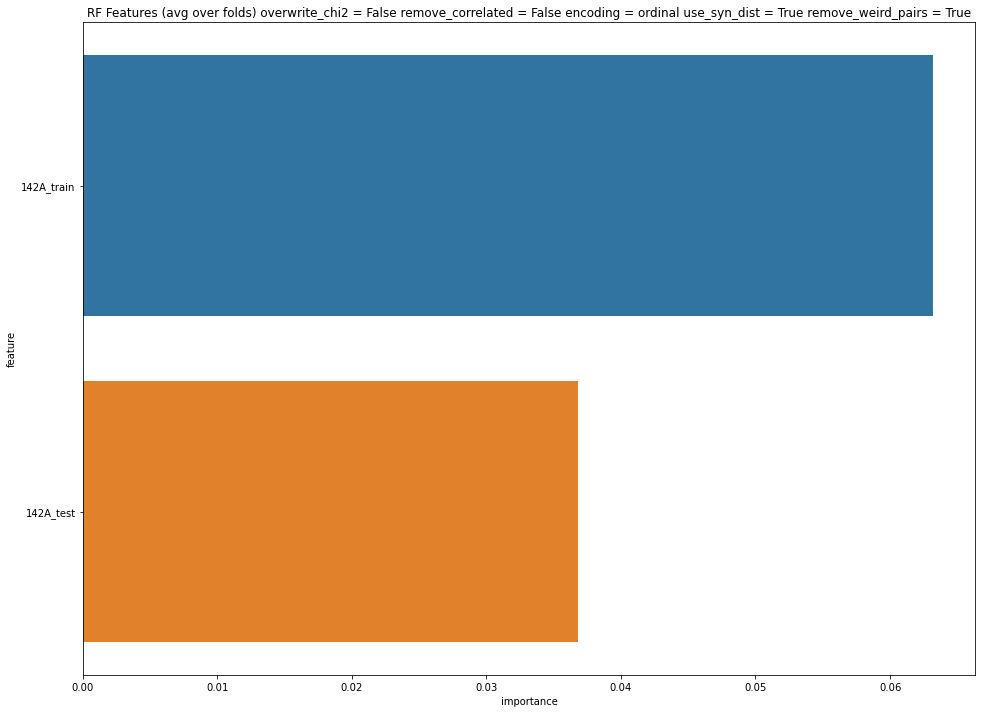

In [40]:
areas = []
metrics = []
for area in groups:
    group_range = groups[area]
    group_cols = [col for col in final_feat_cols if int(re.match("\d*", col).group()) in group_range]
    print("Group",area)
    X = final_df[group_cols]
    y = final_df['acc']
    results, model = train_model(X,y,folds,params=None,model_type='rf')
    areas.append(area)
    metrics.append(results['metrics'])

In [41]:
group_results = pd.concat(metrics)
group_results["group"] = areas

In [42]:
group_results.sort_values(by="test")

,train,test,group
rmse,0.016393,0.040198,order
rmse,0.017872,0.046904,nom_cat
rmse,0.018982,0.049096,simp_claus
rmse,0.020234,0.055033,verb_cat
rmse,0.039918,0.065147,lexicon
rmse,0.057115,0.079151,nom_synt
rmse,0.072227,0.087633,morphology
rmse,0.071364,0.092393,comp_sent
rmse,0.109925,0.111144,other


### Comparing to syntactical distance

#### Predict just with word order and syn_dist

Model type rf

Mean fold metrics


,train,test
rmse,0.017456,0.045664


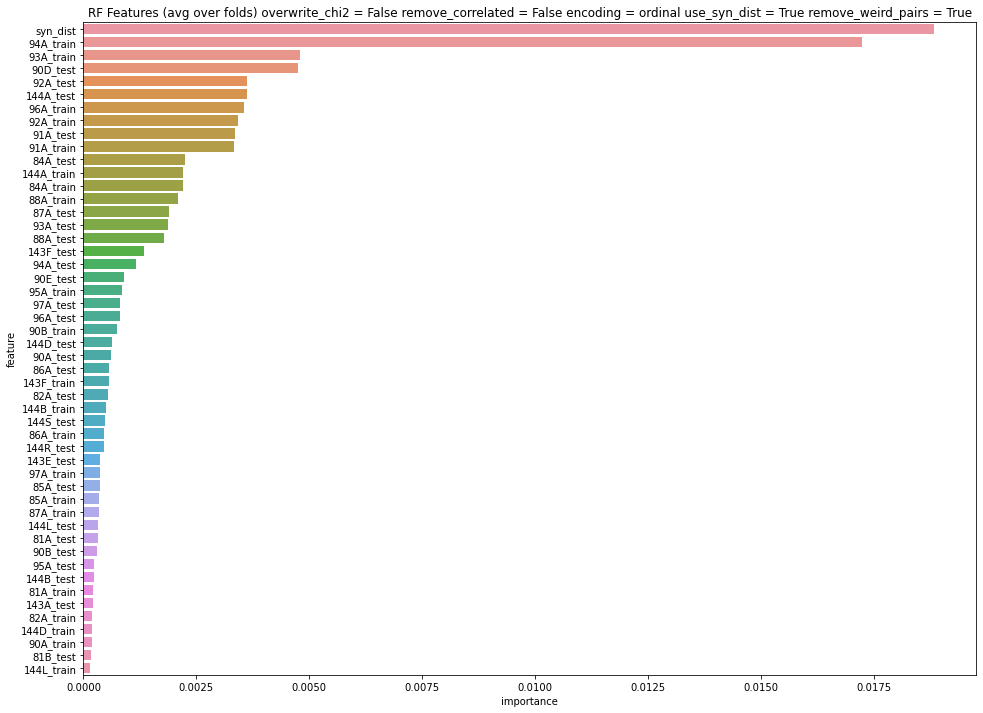

In [43]:
order_cols = [col for col in final_feat_cols if int(re.match("\d*", col).group()) in groups["order"]]
X = final_df[order_cols+["syn_dist"]]
y = final_df['acc']
results, model = train_model(X,y,folds,params=None,model_type='rf')

#### Predict with all features and syntactical distance

Model type rf

Mean fold metrics


,train,test
rmse,0.01582,0.040758


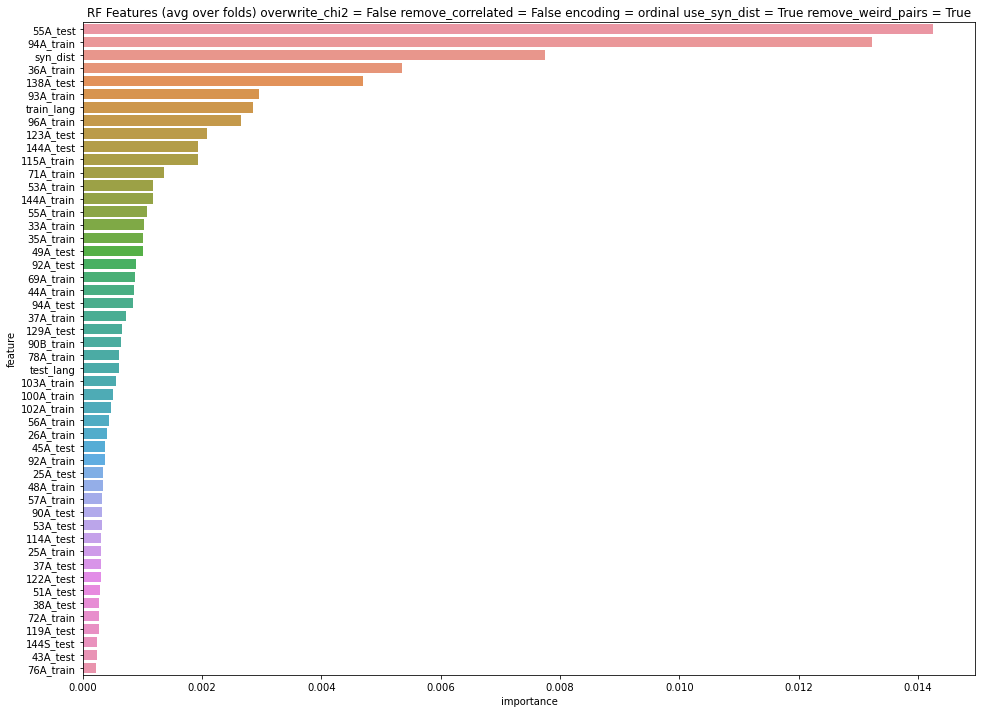

In [44]:
X = final_df.drop(['acc','f1'],axis=1)
y = final_df['acc']
results, model = train_model(X,y,folds,params=None,model_type='rf')

#### Predict with only syntactical distance

We tried polynomial regression but when trying to find the best polynomial, the results were be very unstable so we settled on linear regression.

In [45]:
X = final_df[['syn_dist']]
y = final_df['acc']
results, model = train_model(X,y,folds,params=None,model_type='linear',plot_feature_importance=False)

Model type linear

Mean fold metrics


,train,test
rmse,0.09976,0.099831


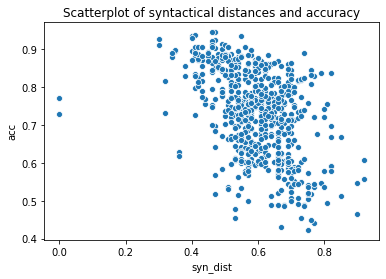

In [46]:
sns.scatterplot(x='syn_dist',y='acc',data=final_df)
plt.title("Scatterplot of syntactical distances and accuracy")
plt.show()

Pearson correlation between accuracy and syntactical distance

In [47]:
from scipy import stats

stats.pearsonr(final_df['acc'], final_df['syn_dist'])

(-0.4675910995579578, 3.2684975750969716e-37)

### Predicting only with "A" features

Model type rf

Mean fold metrics


,train,test
rmse,0.016007,0.042158


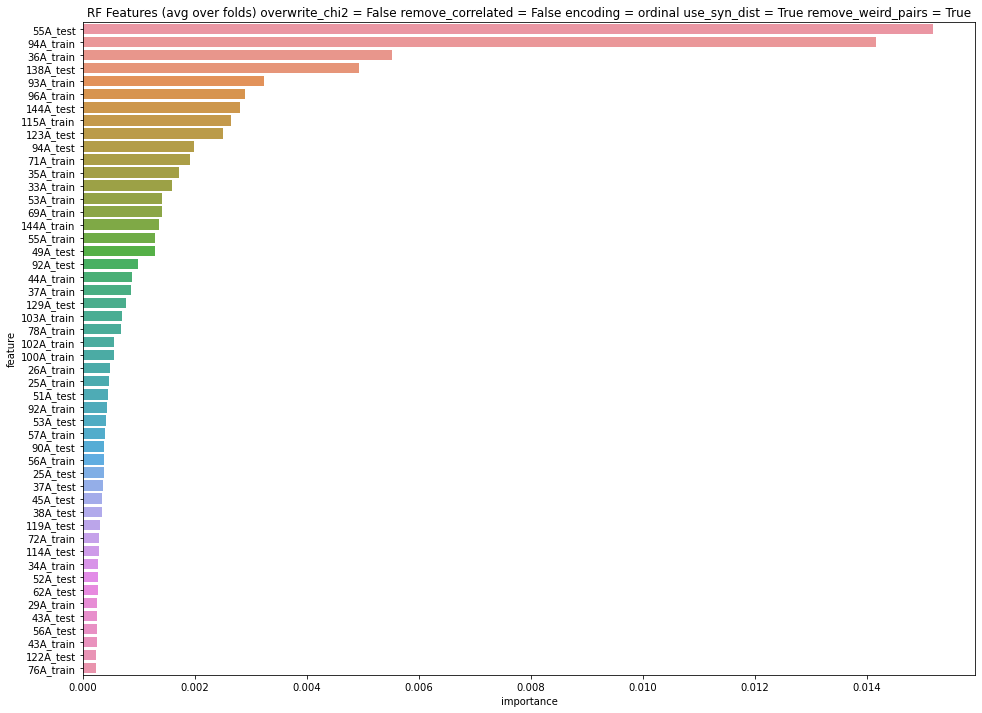

In [48]:
a_feats = [col for col in final_feat_cols if col.split("_")[0][-1]=="A"]

X = final_df[a_feats]
y = final_df['acc']
results, model = train_model(X,y,folds,params=None,model_type='rf')

### Predicting only with WBO features 

Model type rf

Mean fold metrics


,train,test
rmse,0.073116,0.085102


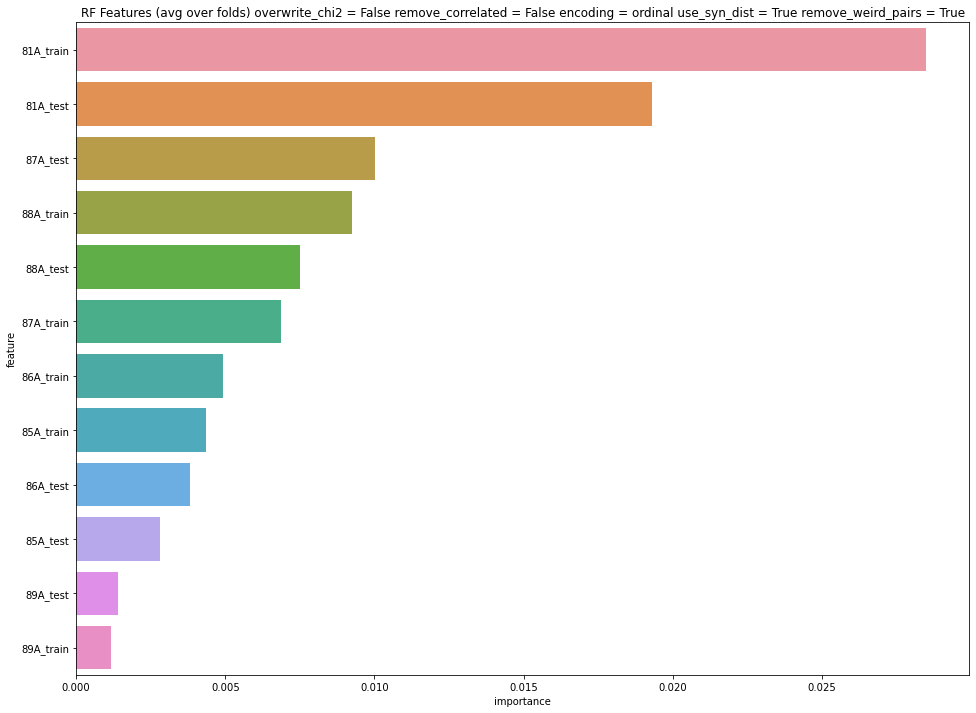

In [49]:
wbo = ['81A Order of Subject, Object and Verb',
'85A Order of Adposition and Noun Phrase',
'86A Order of Genitive and Noun',
'87A Order of Adjective and Noun',
'88A Order of Demonstrative and Noun',
'89A Order of Numeral and Noun']

wbo_cols = [col.split()[0]+"_train" for col in wbo]+ [col.split()[0]+"_test" for col in wbo]

X = final_df[wbo_cols]
y = final_df['acc']
results, model = train_model(X,y,folds,params=None,model_type='rf')

## Miscallenous

### MRMR - feature selection

In [ ]:
from skfeature.function.information_theoretical_based import MRMR
m = MRMR.mrmr(final_df.drop(['acc','f1'],axis=1).to_numpy(),final_df['acc'])
mrmr_top50 = [final_df.drop(['acc','f1'],axis=1).columns[i] for i in m[0][:50]]
for feat in ['144N_test', '143B_test', '143B_train', '144N_train']:
    mrmr_top50.remove(feat)
print("Top 50 features selected by MRMR")
print(mrmr_top50)

### Display geographical map of languages

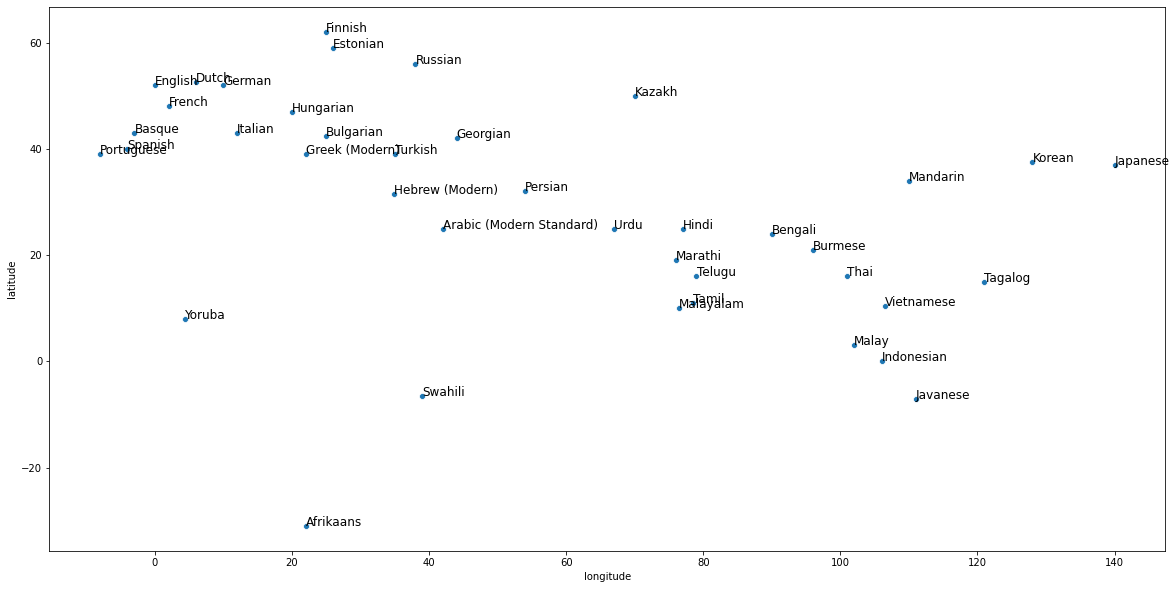

In [51]:

plt.figure(figsize=(20,10))

p1 = sns.scatterplot(x="longitude", y="latitude", data=lang_feats)
for line in range(0,lang_feats.shape[0]):
     p1.text(lang_feats.longitude[line]+0.01, lang_feats.latitude[line], 
     lang_feats.Name[line], horizontalalignment='left', 
     size='large', color='black')